# THE BOOTSTRAP

Bootstrap is a statistical technique used in Machine Learning to improve the estimation of a model's accuracy. It works by randomly selecting a subset of data from the original dataset, with replacement, meaning the same data point can be chosen more than once. This subset is then used to train the model, and the process is repeated multiple times. Each time, the model's performance is evaluated, and the results are averaged to get a more accurate estimate of the model's performance on unseen data.

Bootstrap is useful in Machine Learning because it provides a way to estimate the accuracy of a model in situations where we might not have a lot of data or where the data is too costly to obtain. It allows us to make the most out of our existing data by reusing it in a smart way to estimate how well our model is likely to perform in the real world, thus making our model more robust and reliable.

In this session, we will explore the uses of Bootstrap for two purposes: estimating statistics and assessing the performance an OLS model.

## 1. Install and import libraries

In [1]:
# %pip install statsmodels

In [2]:
# Basic
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Statsmodels
import statsmodels.api as sm

# Plotting
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

C:\Users\dell\AppData\Local\Temp\ipykernel_17444\1875192560.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 2. Estimate the accuracy of an statistic

In this section, we explore the use of bootstrap to calculate the accuracy of a statistic of interest. Our example focuses on determining investment allocations. Specifically, we aim to invest a fixed sum of money across two financial assets yielding returns of X and Y, respectively. These returns are random quantities, leading to variability in the investment's outcome. Our goal is to allocate a fraction $\alpha$ of our money in X, with the remainder, $1 - \alpha$, in Y, to minimize the total risk, or variance, of our investment. The variance we seek to minimize is $Var(\alpha X + (1-\alpha)Y)$.

The optimal value of $ \alpha $ that minimizes this risk is given by the formula:

$$ 
\alpha = \frac{\sigma^2_Y - \sigma_{XY}}{\sigma^2_X + \sigma^2_Y - 2\sigma_{XY}}
$$ 

where:

$$\sigma^2_X = Var(X)$$
$$\sigma^2_Y = Var(Y)$$
$$\sigma_{XY} = Cov(X, Y)$$

We start by loading data from the 'Portfolio' dataset:

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/qlabpucp/datasets/main/datasets/portafolio.csv')
data = data.drop(columns=['Unnamed: 0'])

In [4]:
def estimate_alpha(data, idx, x, y):

    """
    Objective:
    - Calculate the optimal allocation fraction, alpha, for minimizing the variance 
      of a portfolio consisting of two financial assets. This allocation fraction represents 
      the proportion of the total investment to be allocated to the first asset (X) to achieve 
      minimum portfolio risk, based on historical data of the assets' returns.

    Input:
    - data: A pandas DataFrame containing historical return data for the assets.
    - idx : Indices or a boolean array to filter the data for the calculation.
    - x   : The column name in 'data' corresponding to asset X's returns.
    - y   : The column name in 'data' corresponding to asset Y's returns.

    Output:
    - alpha: The calculated optimal allocation fraction for asset X. 
    """

    cov = np.cov(data[[x, y]].loc[idx], rowvar=False)
    alpha = ((cov[1,1] - cov[0,1]) / (cov[0,0]+cov[1,1]-2*cov[0,1]))
    
    return round(alpha,4)

Let's now apply our function to calculate the optimal allocation fraction, $\alpha$, using the entire dataset

In [5]:
estimate_alpha(data, range(100), 'X', 'Y')

0.5758

Now, we'll estimate $\alpha$ by selecting 100 random observations with replacement, a process equivalent to constructing a new dataset using the bootstrap technique

In [6]:
choice = np.random.default_rng(0).choice(100, 100, replace = True)
estimate_alpha(data, choice, 'X', 'Y')

0.6074

Now, let's develop a function designed to compute the bootstrap standard error, applicable for calculating various statistics:

- The standard error is calculated using the formula:

$$ SE = \sqrt{\frac{1}{b} \sum_{i=1}^{b} \hat{\theta}_i^2 - \left(\frac{1}{b} \sum_{i=1}^{b} \hat{\theta}_i\right)^2} $$

- This formula is an application of the standard deviation formula to the bootstrap estimates. The first term inside the square root, $\frac{1}{b} \sum_{i=1}^{b} \hat{\theta}_i^2$, calculates the average of the squares of the estimates. Conversely, the second term, $\left(\frac{1}{b} \sum_{i=1}^{b} \hat{\theta}_i\right)^2$, computes the square of the average of the estimates. The variance of the bootstrap estimates is derived from the difference between these two terms, and taking the square root of this variance yields the standard error.


In [7]:
def boot_SE(func, data, x, y, n=None, b=1000, seed = 0):

    """
    Objective:
    - Calculate the bootstrap standard error (SE) for the output of a specified function, 
      which estimates a parameter (like alpha) based on a dataset. This method involves 
      generating multiple bootstrapped samples of the dataset, applying the function to 
      each sample, and then calculating the standard deviation of the resulting estimates 
      to obtain the SE

    Input:
    - func: The function for which the bootstrap SE is being calculated
    - data: A pandas DataFrame
    - x, y: Column names in 'data' corresponding to the variables of interest for 'func'
    - n   : The number of observations to sample with replacement for each bootstrap iteration
            If None, uses the full dataset size
    - b   : The number of bootstrap iterations/samples to generate
    - seed: A seed for the random number generator to ensure reproducibility

    Output:
    - The calculated bootstrap standard error of the function's estimate based on the input data
    - A list of all bootstrap estimates generated during the process
    """

    choice = np.random.default_rng(seed)
    first_ = 0
    second_ = 0
    n = n or data.shape[0]
    estimates = []

    for sample in range(b):
        idx = choice.choice(data.index, n, replace = True)
        var_ = func(data, idx, x, y) 
        first_ += var_
        second_ += var_**2
        estimates.append(var_)

    se = np.sqrt(second_ / b - (first_ / b)**2)

    return round(se,4), estimates

Now, we will apply the previously defined function to evaluate the precision of our estimates. By selecting 100 observations with replacement, we will generate 1,000 bootstrapped datasets. Then, we'll compute the standard error across all these datasets to assess the accuracy of our estimations.


In [8]:
alpha_SE, estimates = boot_SE(estimate_alpha, data, 'X', 'Y', n = 100, b = 1000, seed = 0)
print(f'Deviation Error at 1000 bootstraped datasets: {alpha_SE}')

Deviation Error at 1000 bootstraped datasets: 0.0912


Next, let's check the distribution of alpha estimated obtained from bootstrapped datasets through a density plot. The plot features a blue shaded area indicating the density of alpha estimates, with a red vertical line marking the mean of these estimates.

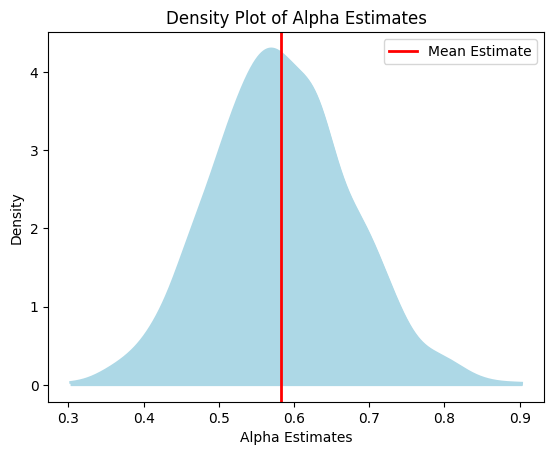

In [9]:
# Estimating the density of the bootstrap estimates
density = gaussian_kde(estimates)
x_vals = np.linspace(min(estimates), max(estimates), 1000)
y_vals = density(x_vals)

# Plotting the density
plt.fill_between(x_vals, y_vals, color="lightblue")
plt.plot(x_vals, y_vals, color="lightblue", lw=2)
plt.axvline(x=np.mean(estimates), color="red", lw=2, label='Mean Estimate')

plt.xlabel("Alpha Estimates")
plt.ylabel("Density")
plt.title("Density Plot of Alpha Estimates")
plt.legend()
plt.show()

## 2. Estimate the accuracy of a Linear Regresion model

Just like the function we designed to estimate alpha, let's now create a function to compute the coefficients of an Ordinary Least Squares (OLS) model

In [10]:
def OLS_params(data, idx, x_vars, y):

    """
    Objective:
    - To calculate the parameters (coefficients) of an Ordinary Least Squares (OLS) regression model. 
      This model is fitted using a subset of the provided dataset, specified by the given indices. 

    Input:
    - data  : A pandas DataFrame containing the dataset.
    - x_vars: A list of column names corresponding to the independent variables.
    - y     : target variable.
    - idx   : An array-like object containing the indices of the observations to be used in the model fitting. 

    Output:
    - params: A Series containing the parameters (coefficients) of the fitted OLS regression model.
    """

    data_ = data.loc[idx]
    Y_ = data_[y]
    X_ = data_[x_vars]
    X_ = sm.add_constant(X_) 
    params = sm.OLS(Y_, X_).fit().params

    return params

Now let's load the ``auto`` dataset

In [11]:
data_auto = pd.read_csv('https://raw.githubusercontent.com/qlabpucp/datasets/main/datasets/auto.csv')
data_auto = data_auto.drop(columns=['Unnamed: 0', 'name'])

Now, let's estimate the coefficientes for the `intercept` and `horsepower` terms over 10 different bootstrap samples

In [12]:
n = data_auto.shape[0]
choice = np.random.default_rng(0)
boot_indexes = [choice.choice(n, n, replace=True) for sample in range(10)]
boot_params = [OLS_params(data_auto, idx, 'horsepower', 'mpg') for idx in boot_indexes]

We can print the results

In [13]:
for i, params in enumerate(boot_params, start=1):
    print(f"Sample {i}:")
    for var, value in params.items():
        print(f"{var}: {value:.3f}")
    print()

Sample 1:
const: 39.881
horsepower: -0.157

Sample 2:
const: 38.733
horsepower: -0.147

Sample 3:
const: 38.317
horsepower: -0.144

Sample 4:
const: 39.914
horsepower: -0.158

Sample 5:
const: 39.433
horsepower: -0.151

Sample 6:
const: 40.366
horsepower: -0.159

Sample 7:
const: 39.623
horsepower: -0.154

Sample 8:
const: 39.058
horsepower: -0.150

Sample 9:
const: 38.667
horsepower: -0.145

Sample 10:
const: 39.643
horsepower: -0.156



Now we can estimate the Standard Error for coefficients of the terms using 1 000 bootstraped samples

In [14]:
boot_se_lr, estimates = boot_SE(OLS_params, data_auto, 'horsepower', 'mpg', b=1000, seed=10)
print(boot_se_lr)

const         0.8488
horsepower    0.0074
dtype: float64


Let's estimate the Standard Error for coefficients using a standard formula. Then, we will compare these results with the ones obtained by bootstrap.

In [15]:
X = sm.add_constant(data_auto[['horsepower']])
Y = data_auto['mpg']

model = sm.OLS(Y, X).fit()
data_auto['predicted_mpg_lr'] = model.predict(X)
print(round(model.bse, 4))

const         0.7175
horsepower    0.0064
dtype: float64


Estimations obtained by the Bootstrap approach are somewhat different from those calculated using the standard formula. The differences do not imply a problem with the bootstrap method. Instead, it suggests that bootstrap might be providing a more accurate estimate of the standard errors. It happens because the traditional formulas depend on assumptions that may not hold true in all scenarios:

- Utilizing a linear model in the presence of non-linear data relationships can inflate residuals and, by extension, the estimated noise variance $ \sigma^2 $, resulting in exaggerated standard errors. 
- Traditional methods presuppose that independent variables are fixed, ignoring the reality that variability might also stem from these variables, not just from the error terms $ \epsilon_i $.

Bootstrap methods do not rely on the specific assumptions required by the traditional formulas, such as the distribution of $ x_i $ or the linearity of the relationship between $ x_i $ and $ y $. This makes bootstrap a more flexible and potentially more accurate method for estimating standard errors, especially in situations where the assumptions behind traditional methods do not hold.

Now, let's examine the Standard Errors obtained through a Polynomial Approach. For this purpose, we create polynomial features of degree two:

In [16]:
# Create polynomical features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(data_auto[['horsepower']])

# Define the names of the new column
poly_feature_names = [f"horsepower^{i}" for i in range(1, 3)]

# Add new columns to the existing dataframe
for i, name in enumerate(poly_feature_names):
    data_auto[name] = X_poly[:, i]

Here we fit a polynomial model and estimate the coefficients Standard Error using 1 000 bootstrap samples

In [17]:
boot_se_qd, estimates = boot_SE(OLS_params, data_auto, poly_feature_names, 'mpg', b=1000, seed=0)
print(boot_se_qd)

const           2.0678
horsepower^1    0.0330
horsepower^2    0.0001
dtype: float64


Now we estimate the coefficient Standard Error using the standardized formula provided by the attribute `.bse` from the Statsmodels package

In [18]:
X_quad = sm.add_constant(data_auto[poly_feature_names])
Y = data_auto['mpg']

model_quad = sm.OLS(Y, X_quad).fit()
data_auto['predicted_mpg_quad'] = model_quad.predict(X_quad)
print(round(model_quad.bse, 4))

const           1.8004
horsepower^1    0.0311
horsepower^2    0.0001
dtype: float64


The estimated Standard Errors from both approaches are now more similar. This improvement occurs because the quadratic model provides a better fit to the data compared to the linear model. Specifically, since the relationship between X and Y appears to be non-linear, the quadratic model results in a noise variance $ \sigma^2 $ estimate that is less inflated than what is observed with the linear model.

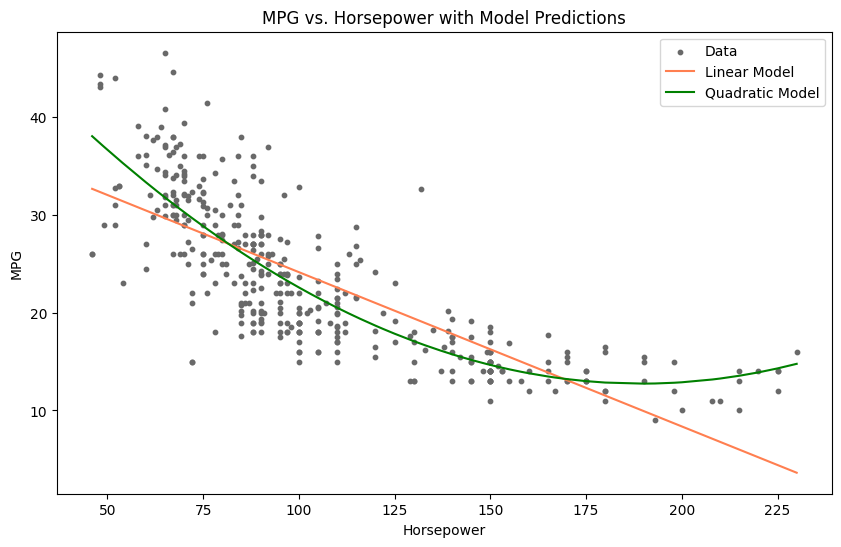

In [19]:
# Sort dataframe by 'horsepower'
data_auto_sorted = data_auto.sort_values(by='horsepower')

# Scatter plot de 'mpg' vs. 'horsepower'
plt.figure(figsize=(10, 6))
plt.scatter(data_auto_sorted['horsepower'], data_auto_sorted['mpg'], color='dimgray', label='Data', s=10)

# Linear predictions
plt.plot(data_auto_sorted['horsepower'], data_auto_sorted['predicted_mpg_lr'], color='coral', label='Linear Model')

# Quadratic predictions
plt.plot(data_auto_sorted['horsepower'], data_auto_sorted['predicted_mpg_quad'], color='green', label='Quadratic Model')

plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('MPG vs. Horsepower with Model Predictions')
plt.legend()
plt.show()